In [528]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
# sys.path.append("../utils")
sys.path.append("../../stimuli")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
from functools import reduce
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import drawing_utils as drawing
import importlib
import scoring

import blockworld_helpers as utils

In [130]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [632]:
experiment_name = 'prior_elicitation_lax_tower_4_block_unique_silhouettes_procedural'
iteration_name = 'pilot-prolific-0'

# experiment_name = 'prior_elicitation_lax_tower_4_block_unique_silhouettes_categorization'
# iteration_name = 'prolific-pilot-0'

In [633]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'../auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')

db = conn['lax']
coll = db[experiment_name]

# ## look up number of trials (including paired-practice)
expected_trials = 26

In [634]:
# really_run = False;

# if really_run:
#     db.drop_collection(experiment_name)

In [635]:
df_all = pd.DataFrame(coll.find({'iterationName': iteration_name}))
# all_data[['gameID','trial_index','label']]

In [636]:
# # Find people who have completed all trials
# query = coll.find({"$and":[
#                         {'trialType':'normal-trial'},
#                         {'eventType':'trialEnd'},
#                         {'iterationName': { '$in': [iteration_name] }},
#                         {'trialNum': numTrials-1}]
#                      })

# complete_data_df = pd.DataFrame(query.sort('absoluteTime'))
# complete_data_ids = list(complete_data_df['gameID'])
# print(str(len(complete_data_ids)) + ' participants found')


# pd.DataFrame(coll.find({'iterationName': iteration_name}))

## Filter out metadata

Info about stimulus set downloaded from mongo.
Contains info about tower type.

In [637]:
df_meta = df_all[(df_all.datatype == 'stim_metadata') &
            (df_all.iterationName == iteration_name)]\
        [["gameID","partitionFamily","splitNumber","stimNumbers", "stimGroups",
          "numGames","experimentType","experimentName", "s3_bucket", "versionInd"]]

In [638]:
df_meta

,gameID,partitionFamily,splitNumber,stimNumbers,stimGroups,numGames,experimentType,experimentName,s3_bucket,versionInd
0,5182-3b2c0380-6cf6-4b77-8e7b-8ca944a38a26,0.0,0.0,"[000, 007, 009, 011, 019, 023, 025, 029, 034, ...","{'100': 'tall', '106': 'neither', '113': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
1,4074-a43b5040-05a9-421f-8716-994e07b3a219,0.0,1.0,"[002, 003, 012, 013, 024, 026, 035, 038, 040, ...","{'101': 'tall', '108': 'neither', '110': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
11,0296-0c9a58f8-9b0e-4357-a90c-c23e2088a269,0.0,2.0,"[001, 004, 010, 015, 030, 037, 039, 042, 043, ...","{'102': 'tall', '103': 'neither', '109': 'tall...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
21,4641-c9c6e48b-2f01-4caf-b9b1-f29659c40474,0.0,3.0,"[005, 008, 016, 017, 020, 033, 036, 044, 050, ...","{'104': 'neither', '105': 'neither', '107': 'n...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
29,6101-d74ea1ce-37dd-4444-b4c8-2ece1f13e4bc,0.0,4.0,"[006, 014, 018, 021, 022, 027, 028, 031, 032, ...","{'112': 'neither', '117': 'neither', '121': 't...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0


## Grab trial data

In [639]:
df_trial = df_all[(df_all.datatype == 'trial_end') &
             (df_all.trial_type == 'stimuli-language-production') &
             (df_all.iterationName == iteration_name)]\
            [['datatype', 'iterationName', 'condition',
       'config_name', 'workerID', 'gameID', 'shuffle', 'trialOrder', 'rt',
       'url', 'trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'view_history', 'label', 'stimId', 'stimURL', 'responses']]

### Add metadata to trial data

In [640]:
# verify stim groups in metadata are correct
dicts = list(df_all[df_all.datatype=='stim_metadata']['stimGroups'])

stim_groups = reduce(lambda dict1, dict2: {**dict1, **dict2}, dicts)
pd.Series(list(stim_groups.values())).value_counts()

# assign stim groups from metadata (althoug)
df_trial['stim_group'] = df_trial['stimId'].apply(lambda stim: stim_groups[stim])
df_trial = df_trial.merge(df_meta, how='left', on='gameID')

## Todo: get complete data sets

In [641]:
df_trial.groupby('gameID')['trial_index'].last()

gameID
0296-0c9a58f8-9b0e-4357-a90c-c23e2088a269     8.0
4074-a43b5040-05a9-421f-8716-994e07b3a219     7.0
4641-c9c6e48b-2f01-4caf-b9b1-f29659c40474     2.0
5182-3b2c0380-6cf6-4b77-8e7b-8ca944a38a26     4.0
6101-d74ea1ce-37dd-4444-b4c8-2ece1f13e4bc    25.0
Name: trial_index, dtype: float64

## Which batches need re-running? (move to stim_partitioning.ipynb)

TODO: Find incomplete datasets that need to be given to another participant and upload to mongo

- get each gameID + their partitionFamily splitNumber stimNumbers, 
- get number of trials
- work out which batches need to be re-run

In [643]:
df_trial

,datatype,iterationName,condition,config_name,workerID,gameID,shuffle,trialOrder,rt,url,...,stim_group,partitionFamily,splitNumber,stimNumbers,stimGroups,numGames,experimentType,experimentName,s3_bucket,versionInd
0,trial_end,pilot-prolific-0,all,lax-tower-4-block-unique-silhouettes-procedural,60ffb005bafbac5c43cbb053,4074-a43b5040-05a9-421f-8716-994e07b3a219,NaN,NaN,135276.7,NaN,...,wide,0.0,1.0,"[002, 003, 012, 013, 024, 026, 035, 038, 040, ...","{'101': 'tall', '108': 'neither', '110': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
1,trial_end,pilot-prolific-0,all,lax-tower-4-block-unique-silhouettes-procedural,6107850120a7fe1e101d17d5,5182-3b2c0380-6cf6-4b77-8e7b-8ca944a38a26,NaN,NaN,223205.2,NaN,...,neither,0.0,0.0,"[000, 007, 009, 011, 019, 023, 025, 029, 034, ...","{'100': 'tall', '106': 'neither', '113': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
2,trial_end,pilot-prolific-0,all,lax-tower-4-block-unique-silhouettes-procedural,60ffb005bafbac5c43cbb053,4074-a43b5040-05a9-421f-8716-994e07b3a219,NaN,NaN,154092.0,NaN,...,neither,0.0,1.0,"[002, 003, 012, 013, 024, 026, 035, 038, 040, ...","{'101': 'tall', '108': 'neither', '110': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
3,trial_end,pilot-prolific-0,all,lax-tower-4-block-unique-silhouettes-procedural,6107850120a7fe1e101d17d5,5182-3b2c0380-6cf6-4b77-8e7b-8ca944a38a26,NaN,NaN,180096.6,NaN,...,neither,0.0,0.0,"[000, 007, 009, 011, 019, 023, 025, 029, 034, ...","{'100': 'tall', '106': 'neither', '113': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
4,trial_end,pilot-prolific-0,all,lax-tower-4-block-unique-silhouettes-procedural,6107850120a7fe1e101d17d5,5182-3b2c0380-6cf6-4b77-8e7b-8ca944a38a26,NaN,NaN,340038.8,NaN,...,neither,0.0,0.0,"[000, 007, 009, 011, 019, 023, 025, 029, 034, ...","{'100': 'tall', '106': 'neither', '113': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
5,trial_end,pilot-prolific-0,all,lax-tower-4-block-unique-silhouettes-procedural,56fea1c604254b000f0065a9,0296-0c9a58f8-9b0e-4357-a90c-c23e2088a269,NaN,NaN,125888.0,NaN,...,neither,0.0,2.0,"[001, 004, 010, 015, 030, 037, 039, 042, 043, ...","{'102': 'tall', '103': 'neither', '109': 'tall...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
6,trial_end,pilot-prolific-0,all,lax-tower-4-block-unique-silhouettes-procedural,56fea1c604254b000f0065a9,0296-0c9a58f8-9b0e-4357-a90c-c23e2088a269,NaN,NaN,68761.0,NaN,...,neither,0.0,2.0,"[001, 004, 010, 015, 030, 037, 039, 042, 043, ...","{'102': 'tall', '103': 'neither', '109': 'tall...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
7,trial_end,pilot-prolific-0,all,lax-tower-4-block-unique-silhouettes-procedural,56fea1c604254b000f0065a9,0296-0c9a58f8-9b0e-4357-a90c-c23e2088a269,NaN,NaN,91057.0,NaN,...,wide,0.0,2.0,"[001, 004, 010, 015, 030, 037, 039, 042, 043, ...","{'102': 'tall', '103': 'neither', '109': 'tall...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
8,trial_end,pilot-prolific-0,all,lax-tower-4-block-unique-silhouettes-procedural,56fea1c604254b000f0065a9,0296-0c9a58f8-9b0e-4357-a90c-c23e2088a269,NaN,NaN,73032.0,NaN,...,neither,0.0,2.0,"[001, 004, 010, 015, 030, 037, 039, 042, 043, ...","{'102': 'tall', '103': 'neither', '109': 'tall...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
9,trial_end,pilot-prolific-0,all,lax-tower-4-block-unique-silhouettes-procedural,56fea1c604254b0

## Data preprocessing

In [644]:
list(df_trial.groupby('stimId').first()['label'])

['First I would draw two blue horizontal rectangles of the same size one on the bottom one on top, perfectly aligned so it looks like a square in the middle of the page. Then I would draw one rust orange vertical rectangle on the left side of the blue rectangles, making it the same height as the square is so the rust orange rectangle is the exact same size of the blue rectangle but just turned vertically. Then I would do the exact same thing with another rust orange rectangle on the right side.',
 "place a horizontal blue block...then I would place a red block vertically aligning with the end of the first blue block...then I would place another blue block horizontally aligning with the topmost end of the red block...then I would vertically place a red block so that it aligns with the empty end of the blue block to make an almost 'n' shape",
 'to make this image i would create a blue rectangle to the right laying hamburger way, then i would out another blue hamburger rectangle and lay i

## Basic plots to test data

  - Make some simple plots
	- Description length over trial num
	- For each tower:
		- display responses
		- variance in desc length
		- mean desc length

In [645]:
# setup block display
block_dims = [(2,1),(1,2)]
block_colors = ['#0A2FB3','#B32F0A']
black = ['#000000','#000000'] # used to display silhouettes
grey = ['#333333','#333333']
world_width = 8
world_height = 8
world_center = int((world_width-1)/2)

In [646]:
towers = pd.read_pickle("../../stimuli/tower_4_block_unique_silhouettes/tower_4_block_unique_silhouettes.pkl")

In [647]:
towers_with_labels = df_trial[['stimId','label','gameID']].groupby('stimId')
# tower_ids = towers_with_labels.first().reset_index()['stimId']

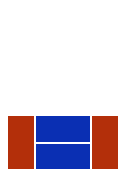

000
['First I would draw two blue horizontal rectangles of the same size one on the bottom one on top, perfectly aligned so it looks like a square in the middle of the page. Then I would draw one rust orange vertical rectangle on the left side of the blue rectangles, making it the same height as the square is so the rust orange rectangle is the exact same size of the blue rectangle but just turned vertically. Then I would do the exact same thing with another rust orange rectangle on the right side.']


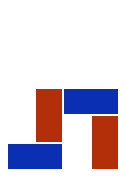

010
["place a horizontal blue block...then I would place a red block vertically aligning with the end of the first blue block...then I would place another blue block horizontally aligning with the topmost end of the red block...then I would vertically place a red block so that it aligns with the empty end of the blue block to make an almost 'n' shape"]


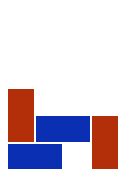

012
['to make this image i would create a blue rectangle to the right laying hamburger way, then i would out another blue hamburger rectangle and lay it on top and moved towards the right, then i would put a red rectangle laying hot dog wise on the first blue retangle, and another to the right of them.\n']


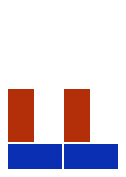

014
['to make this image i would place two blue blocks side by side horizontally. then I would put one vertical red block on each by aligning their left sides.']


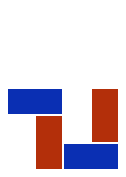

018
['to make this image i would place a horizontal blue block. then i would place a vertical red block on top so that their right sides are aligned. Then i would place a vertical red block to the left of the blue block. then i would place a horizontal blue block on top the second red block so that their right sides are aligned.']


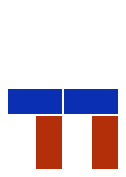

022
['to make this image i would place two vertical red blocks with the distance of another red block between them. then id place a horizontal blue block on each by aligning the right sides of each blue and their corresponding red block.']


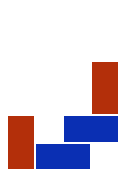

027
['to make this image i would place a horizontal blue block. then i would place a vertical red block to the left of it. then i would place a second horizontal blue block on top the first by having its right side float and left side touch. then i would place a vertical red block on top the second blue block by having their right sides align.']


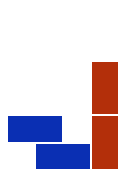

028
['to make this image i would stack two vertical red blocks. then i would place a horizontal blue block to the left of them. then i would stack a second blue block on the first so that its left half is floating and right half is touching.']


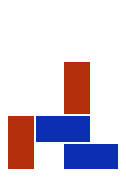

031
['to make this image i would place a horizontal blue block. then i would place a horizontal blue block on top by having its left half float and right half be on the block. then i would place a vertical red block on the second blue block by aligning their right sides. then i would place a vertical red block on the right side of the blocks so that it is touching the left side of the second blue block.']


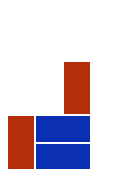

032
['to make this image i would horizontally stack two blue blocks. Then I would place a vertical red block on their left side. Then I would place a vertical red block on top to the two blue blocks by aligning their right sides.']


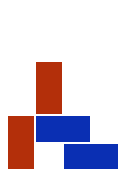

038
['connect two blue rectangles laying in a staircase form, and then I would lay one on top of the stair shape and another to the left of them.']


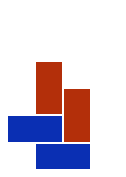

040
['create a fish braid pattern with two red on the right and two blue on the lefft.']


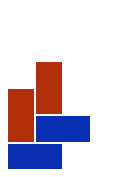

041
["draw a blue horizontal rectangle on the bottom. Then I would draw another blue horizontal rectangle of the exact same size sitting on top of the first blue rectangle centered to the left so there is half of the second rectangle sitting on the first one and half of it hanging off the side. Then I would draw a rust orange vertical rectangle the same size as the other rectangles and have it sitting on the first blue rectangle, the bottom would be touching the first blue rectangle and the left side would be touching the second blue rectangle on the left edge. Lastly I would draw another rust orange vertical rectangle the same size as the others, and place it sitting on top of the second blue rectangle centered to the right so it's edge is touching the first rust orange rectangle."]


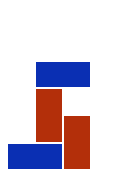

043
['place a horizontal blue block...then I would place a vertical red block at its end...then I would place another vertical red block on the end of and on top of the blue block...then I would place a horizontal blue block on top of the secondmost placed red block']


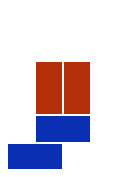

045
['to make this image i would place a horizontal blue block. then i would place another horizontal blue block on top so that its right half is floating and left half is touching. then i would place two vertical red blocks side by side on top of the second blue block.']


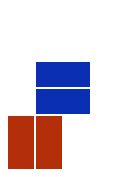

046
['to make this image i would place to vertical red blocks touching together. Then i would place to horizontal blocks on top of the red block on the right.']


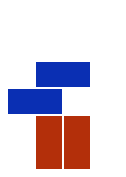

047
['to make this image i would place two vertical red blocks side by side. then i would place a horizontal blue block on the left red block. then i would place a second horizontal blue block on the first so that its right half is floating and left half is touching.']


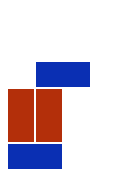

048
['to make this block i would place a blue block horizontally. then I would place to red blocks vertically touching together on top. then I would place a blue block horizontally aligned with the red block on the right.']


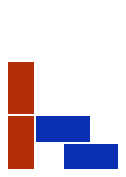

051
["to make this image i would stack two red blocks vertically. then i would place a blue block horizontally the distance of one block's length away  . Then i'd stack another blue block horizontally on the first and align this block to touch the red ones. "]


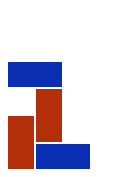

056
['to make this image i would horizontally place a blue block. then i would vertically place a red block to the left of it. then i would place a vertical red block on top of the blue block so that it is touching the other red block. then i would place a horizontal blue block on the second red block. then i would align the right sides of those two final blocks.']


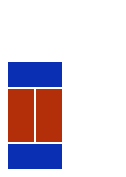

063
['place one blue block horizontally...then I would place both red blocks lengthways aligned to the blue block...then I would place a blue block horizontally so that it aligns with the red blocks']


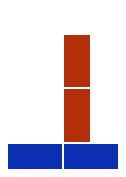

066
["to make this image i would lay two horizontal blue blocks side by side. then i would stack two vertical red blocks and place them on the blue block on the right so that these three blocks' left sides are aligning."]


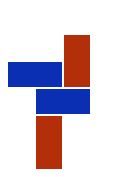

071
["place the two blue blocks together to make a 'z' shape...then I would place a vertical red block at the back of the 'z' shape...then I would place a vertical red block underneath the blue block on the opposite side of the other red block"]


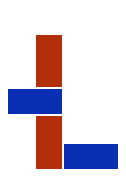

075
['place two red blocks vertically to form a line...then I would place a horizontal blue block aligning with the lowest end of the line of red blocks...then I would shift the topmost red block upwards to form a gap...then I would place a horizontal blue block in this gap aligning with the edge of the red blocks']


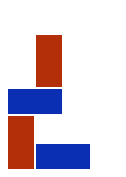

076
['draw a blue horizontal rectangle on the bottom, then draw a rust orange rectangle (the same size) vertically touching the left side of the blue rectangle, then I would draw another blue horizontal rectangle (the same size) on top of the rust orange rectangle but center it so the edges line up and there is half of the rectangle hanging off to the right, lastly I would draw another rust orange vertical rectangle sitting on top of the previous blue rectangle on the right side with the edges lines up flush.']


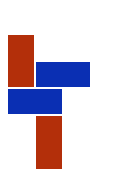

082
['start with a red rectangle laying hotdog, and put two hamburger rectangles laying like a staircase, and the last rectangle laying hotdog on the right corner of the second rectangle.\n']


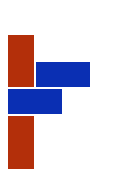

083
['to make this image i would place a vertical red block. then I would place a horizontal blue block on top so that that their left sides are aligned. then i would place a vertical red block on top of both so that all their left sides are aligned. then i would place a horizontal blue block on the remaining space  of the first blue block.']


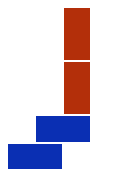

086
['put two red rectangles together, and make a stair going up the the right underneath them. ']


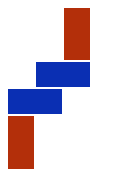

089
['to make this image i would place a vertical red block. then i would put a horizontal blue block on top by aligning their left sides. then I would place a horizontal blue block on top of the other so that its left half is on the block and right half is floating. Then I would place a vertical red block on top of the right side of the second blue block.']


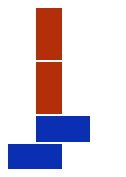

090
['to make this image i would place a horizontal blue block. then i would lay another blue block on top so that it is half way on the other, but its right half is not. then id place two vertically stacked red blocks on the left side of the second blue block.']


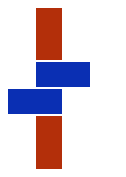

094
['to make this image i would place a vertical red block. then i would place a horizontal blue block on top and have their right sides align. then i would place another blue block on top the first so that its right half is floating and left half is touching. then i would place a vertical red block on top so that its left side is aligned with the second blue blocks left.']


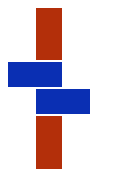

099
['Place two red blocks lengthways...then I would intercept with two blue blocks horizontally...then I would shift the topmost blue block to the left until its rightmost end aligns with the end of the top red block...then I would shift the bottommost blue block to the right until its leftmost end aligns with the end of the bottom red block']


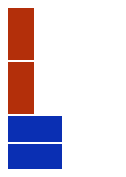

109
['place two vertical red blocks together forming a line...then I would place two blue blocks horiztonally together...then I would join the blue blocks to the end of the red blocks']


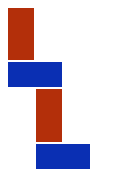

110
['connect two flat rectangles with the red rectangles. ']


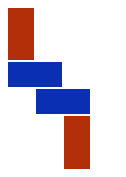

112
['to make this image i would put a vertical red block. then i would place a horizontal blue block on top so that their right sides are alined. then i would put another horizontal blue block on top of the first so that its right half is on the block and left half is floating. then i would put a vertical red block on the left side of the second blue block. ']


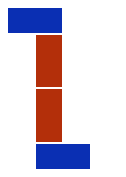

117
['to make this image i would put a horizontal blue block. Then i would stack two vertical red blocks and place them on top of the blue by aligning all of their left sides. Then I would place a horizontal blue block on top of the red by aligning their right sides.']


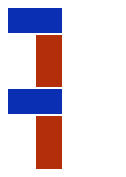

121
['to make this image i would place a vertical red block. then i would put a horizontal blue block by aligning their right sides. then i would put a vertical red block on top by aligning right sides. then i would place another horizontal blue block by aligning their right sides.']


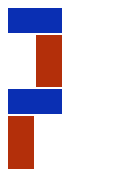

122
['to make this image i would place a vertical red block. Then I would place a horizontal blue block so that their left sides align. Then i would place a vertical red block on the blue one so that their right sides align. then i would place a horizontal blue block on the second red so that their right sides align. ']


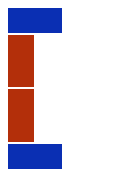

125
['To make this image i would put a blue rectangle horizontally on top of two red rectangles. I would then put a blue rectangle horizontally on the bottom.']


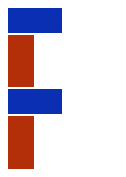

127
['to make this image i would place a vertical red block. then i would place a horizontal blue block on top by having their left sides align. then i would place a vertical red block on top by having their left sides align. then i would place a horizontal blue block by having their left sides align.']


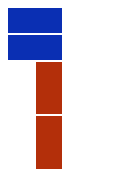

128
['to make this image i would vertically stack two red blocks. then I would place two horizontal blue blocks on top by alining their right sides.']


In [648]:
for towerId, group_df in towers_with_labels:
    utils.draw_tower(utils.worldify(list(towers[towers.tower_number_str == towerId]['stim'])[0],
                                    block_dims = block_dims, 
                                    block_colors = block_colors))
    print(towerId)
    print(list(group_df['label']))

In [649]:
utils.draw_world

<function blockworld_helpers.draw_world(world)>

In [650]:
labels_by_trial_num = df_trial[['stimId','label','gameID','trial_index']].groupby('trial_index')

for trial_num, group_df in labels_by_trial_num:
    print(trial_num)
    print(list(group_df['label']))
    print('\n')
    
    

2.0
['to make this image i would create a blue rectangle to the right laying hamburger way, then i would out another blue hamburger rectangle and lay it on top and moved towards the right, then i would put a red rectangle laying hot dog wise on the first blue retangle, and another to the right of them.\n', 'draw a blue horizontal rectangle on the bottom, then draw a rust orange rectangle (the same size) vertically touching the left side of the blue rectangle, then I would draw another blue horizontal rectangle (the same size) on top of the rust orange rectangle but center it so the edges line up and there is half of the rectangle hanging off to the right, lastly I would draw another rust orange vertical rectangle sitting on top of the previous blue rectangle on the right side with the edges lines up flush.', 'Place two red blocks lengthways...then I would intercept with two blue blocks horizontally...then I would shift the topmost blue block to the left until its rightmost end aligns w

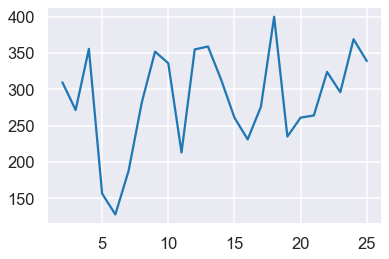

In [651]:
lengths = df_trial[['stimId','label','gameID','trial_index']].groupby('trial_index')['label']\
                    .apply(lambda labels: np.mean([len(label) for label in labels]))
plt.plot(lengths)